In [ ]:
from statsmodels.tsa.stattools import adfuller

In [40]:
def interpret_adf(dftest):
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value', 'Lags Used', 'Observations Used'])
    dfoutput = dfoutput.map(lambda x: round(x,4))
    return dfoutput

In [41]:
interpret_adf(adfuller(df['temperature'].dropna()))
# we cannot reject H0: data is not stationary because p>0.01

Test Statistic         -2.6944
p-value                 0.0750
Lags Used              21.0000
Observations Used    8121.0000
dtype: float64

In [42]:
interpret_adf(adfuller(df['temperature'].diff().dropna()))
# one diff is enough to get stationarity
# we reject H0: data is not stationary because p<0.01

Test Statistic        -12.0586
p-value                 0.0000
Lags Used              20.0000
Observations Used    8121.0000
dtype: float64

In [43]:
df.columns

Index(['temperature', 'humidity', 'light', 'co2', 'humidity_ratio',
       'occupancy'],
      dtype='object')

In [44]:
# interpret_adf(adfuller(df['humidity'].dropna())) # 0.83
interpret_adf(adfuller(df['humidity'].diff().dropna())) # 0.00

Test Statistic         -7.6978
p-value                 0.0000
Lags Used              36.0000
Observations Used    8105.0000
dtype: float64

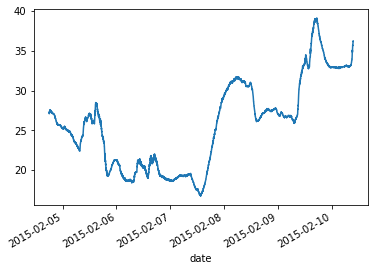

In [45]:
df['humidity'].plot();

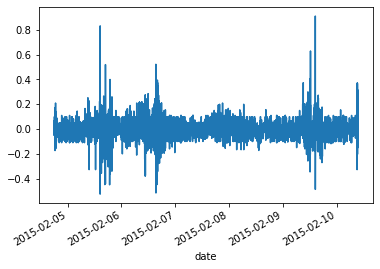

In [46]:
df['humidity'].diff().plot();

In [47]:
interpret_adf(adfuller(df['light'].dropna()))

Test Statistic         -3.3146
p-value                 0.0142
Lags Used              30.0000
Observations Used    8112.0000
dtype: float64

In [48]:
interpret_adf(adfuller(df['light'].diff().dropna()))

Test Statistic        -20.6659
p-value                 0.0000
Lags Used              29.0000
Observations Used    8112.0000
dtype: float64

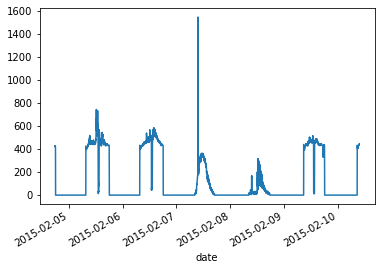

In [49]:
df['light'].plot();

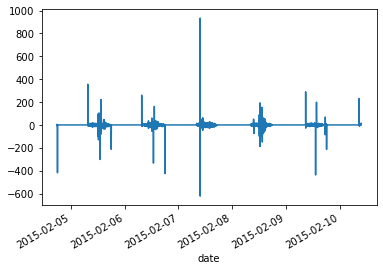

In [50]:
df['light'].diff().plot();

In [51]:
interpret_adf(adfuller(df['co2'].dropna()))

Test Statistic         -3.6390
p-value                 0.0051
Lags Used              35.0000
Observations Used    8107.0000
dtype: float64

In [52]:
interpret_adf(adfuller(df['co2'].diff().dropna()))

Test Statistic         -6.6717
p-value                 0.0000
Lags Used              34.0000
Observations Used    8107.0000
dtype: float64

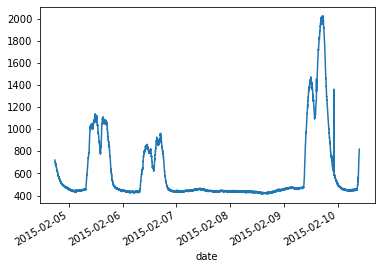

In [53]:
df['co2'].plot();

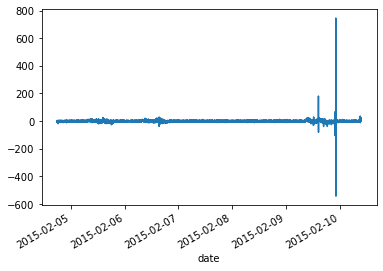

In [54]:
df['co2'].diff().plot();

In [55]:
interpret_adf(adfuller(df['humidity_ratio'].dropna()))

Test Statistic         -1.2797
p-value                 0.6384
Lags Used              27.0000
Observations Used    8115.0000
dtype: float64

In [56]:
interpret_adf(adfuller(df['humidity_ratio'].diff().dropna()))

Test Statistic         -8.0324
p-value                 0.0000
Lags Used              26.0000
Observations Used    8115.0000
dtype: float64

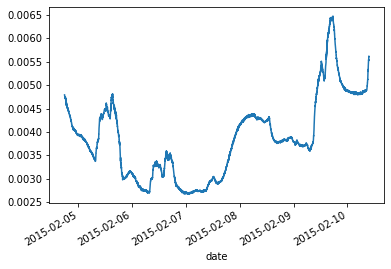

In [57]:
df['humidity_ratio'].plot();

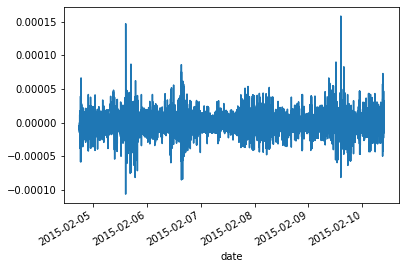

In [58]:
df['humidity_ratio'].diff().plot();

In [59]:
df.head()

,temperature,humidity,light,co2,humidity_ratio,occupancy
date,,,,,,
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [60]:
df['temperature_1diff'] = df['temperature'].diff()
df['humidity_1diff'] = df['humidity'].diff()
df['light_1diff'] = df['light'].diff()
df['co2_1diff'] = df['co2'].diff()
df['humidity_ratio_1diff'] = df['humidity_ratio'].diff()

In [61]:
df.head()

,temperature,humidity,light,co2,humidity_ratio,occupancy,temperature_1diff,humidity_1diff,light_1diff,co2_1diff,humidity_ratio_1diff
date,,,,,,,,,,,
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,NaN,NaN,NaN,NaN,NaN
2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1,-0.03,-0.0045,3.5,-7.25,-0.000010
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,0.00,-0.0225,-3.5,-0.50,-0.000004
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,0.00,-0.0450,0.0,-5.25,-0.000008
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,-0.05,0.0000,0.0,-3.75,-0.000015


In [62]:
features = ['temperature_1diff', 'humidity_1diff', 'light_1diff', 'co2_1diff', 'humidity_ratio_1diff']

In [63]:
econ_df = df[features].copy()

In [64]:
econ_df.dropna(inplace=True)

In [65]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(econ_df,
                               test_size = 0.25,
                               shuffle=False)

In [66]:
train

,temperature_1diff,humidity_1diff,light_1diff,co2_1diff,humidity_ratio_1diff
date,,,,,
2015-02-04 17:51:59,-0.03,-0.0045,3.5,-7.25,-0.000010
2015-02-04 17:53:00,0.00,-0.0225,-3.5,-0.50,-0.000004
2015-02-04 17:54:00,0.00,-0.0450,0.0,-5.25,-0.000008
2015-02-04 17:55:00,-0.05,0.0000,0.0,-3.75,-0.000015
2015-02-04 17:55:59,0.00,0.0000,-7.0,-3.50,0.000000
...,...,...,...,...,...
2015-02-08 23:32:59,0.00,-0.0500,0.0,-1.00,-0.000007
2015-02-08 23:34:00,0.00,-0.0500,0.0,-0.50,-0.000007
2015-02-08 23:35:00,0.00,0.0000,0.0,3.00,0.000000


In [67]:
test

,temperature_1diff,humidity_1diff,light_1diff,co2_1diff,humidity_ratio_1diff
date,,,,,
2015-02-08 23:38:00,0.00,0.0000,0.0,1.333333,0.000000
2015-02-08 23:38:59,0.00,0.0000,0.0,1.166667,0.000000
2015-02-08 23:39:59,0.00,0.0000,0.0,2.166667,0.000000
2015-02-08 23:41:00,0.00,0.0000,0.0,-5.666667,0.000000
2015-02-08 23:42:00,0.00,0.0000,0.0,0.666667,0.000000
...,...,...,...,...,...
2015-02-10 09:29:00,0.00,0.0475,0.0,7.000000,0.000007
2015-02-10 09:29:59,0.00,-0.1025,0.0,2.250000,-0.000016
2015-02-10 09:30:59,0.05,0.1000,0.0,9.000000,0.000033


In [68]:
from statsmodels.tsa.api import VAR
model = VAR(train)

/Users/cristinasahoo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [69]:
ts_model = model.fit(maxlags=15, ic='aic')

In [1]:
#ts_model.summary()

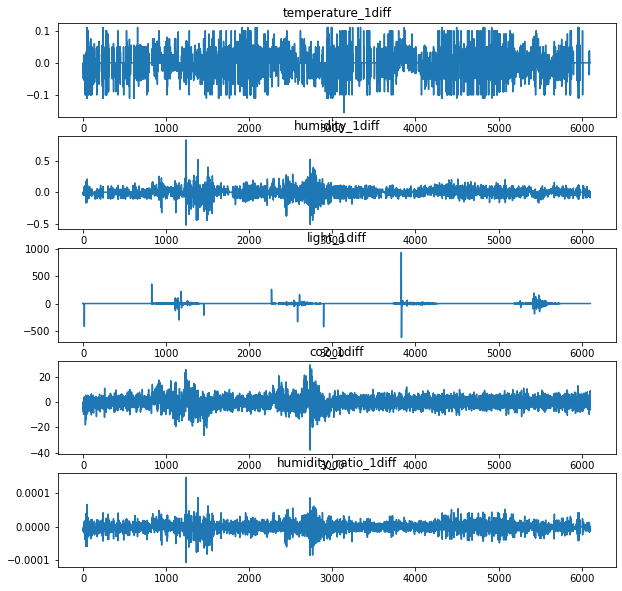

In [71]:
ts_model.plot();

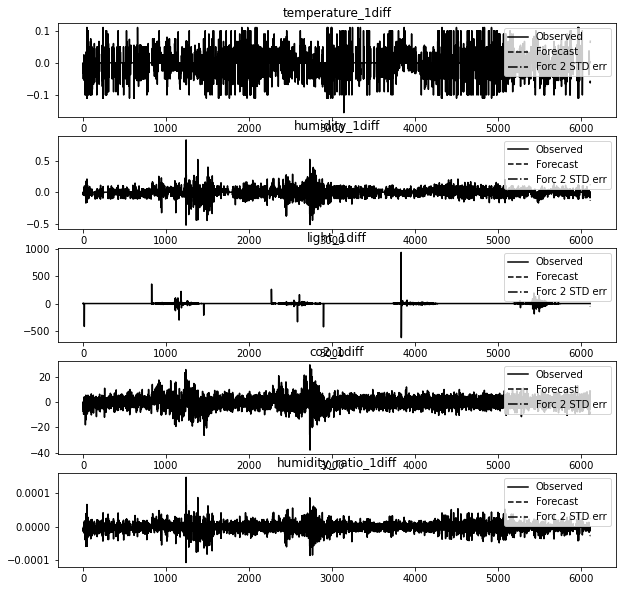

In [72]:
ts_model.plot_forecast(3);

In [73]:
from sklearn.metrics import mean_squared_error

In [74]:
preds = ts_model.forecast(test.values, len(test))

In [75]:
true = test.values

In [76]:
for i in range(test.shape[1]):
    print(f'The test MSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], preds[:, i]), 4)}')

The test MSE on the temperature_1diff data is: 0.0011
The test MSE on the humidity_1diff data is: 0.0045
The test MSE on the light_1diff data is: 283.4587
The test MSE on the co2_1diff data is: 617.2994
The test MSE on the humidity_ratio_1diff data is: 0.0


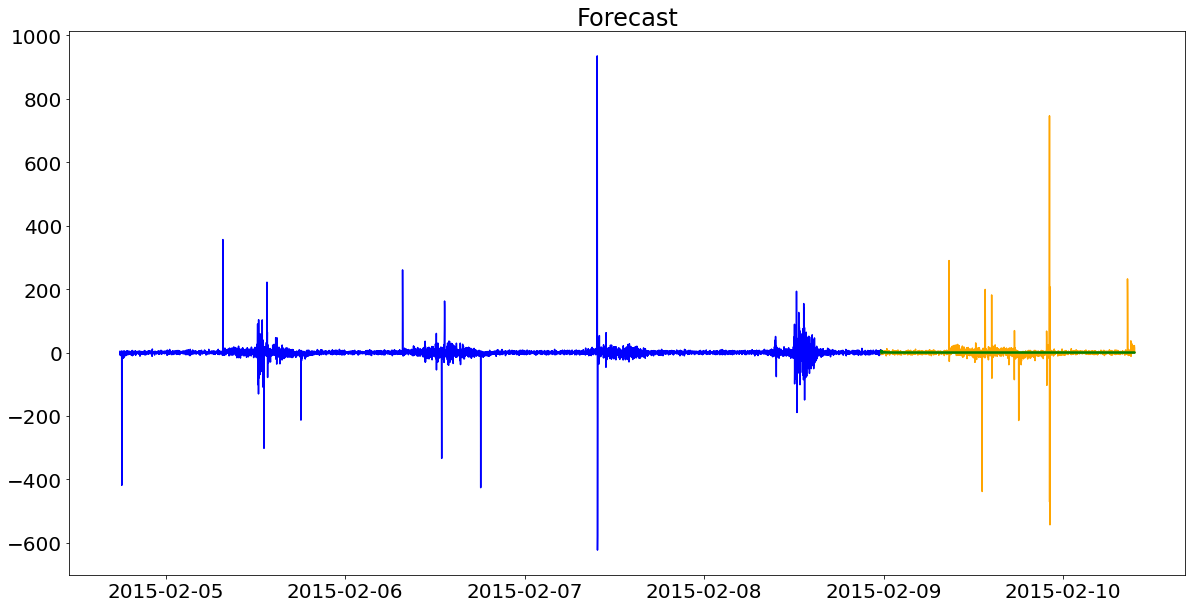

In [77]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train.index, train.values, color = 'blue')

# Plot testing data.
plt.plot(test.index, test.values, color = 'orange')

# Plot predicted test values.
plt.plot(test.index, preds, color = 'green')

# Set label.
plt.title(label = 'Forecast', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [370]:
ss = StandardScaler()

In [371]:
df_sc = ss.fit_transform(df)

In [373]:
df_sc = pd.DataFrame(df_sc, index=df.index, columns=df.columns)

In [374]:
df_sc.head()

,temperature,humidity,light,co2,humidity_ratio,occupancy
date,,,,,,
2015-02-04 17:51:00,2.518470,0.278526,1.573763,0.364948,1.091757,1.926047
2015-02-04 17:51:59,2.488967,0.277713,1.591735,0.341881,1.080555,1.926047
2015-02-04 17:53:00,2.488967,0.273645,1.573763,0.340290,1.075888,1.926047
2015-02-04 17:54:00,2.488967,0.265508,1.573763,0.323587,1.066555,1.926047
2015-02-04 17:55:00,2.439796,0.265508,1.573763,0.311655,1.049523,1.926047
